# Estimate rates from SqRA rate matrix 1D

In [94]:
import sys

%matplotlib ipympl
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import scipy.linalg
import scipy.sparse
import scipy.sparse.linalg
import matplotlib.cm as cm


font = {'size'   : 10}
plt.rc('font', **font)
in2cm = 1/2.54  # centimeters in inches

### Adjacency matrix

In [95]:
def adjancency_matrix_sparse(nbins, nd, periodic=False):
    v = np.zeros(nbins)
    v[1] = 1
    
    if periodic:
        v[-1] = 1
        A0 = scipy.sparse.csc_matrix(scipy.linalg.circulant(v)) #.toarray()
    else:
        A0 = scipy.sparse.csc_matrix(scipy.linalg.toeplitz(v)) #.toarray()
    
    A = A0
    I2 = scipy.sparse.eye(nbins)  #np.eye(nbins)
    for _ in range(1, nd):
        I1 = scipy.sparse.eye(*A.shape) #np.eye(*A.shape)
        A =  scipy.sparse.kron(A0, I1) + scipy.sparse.kron(I2, A)
    return A

## 1D system

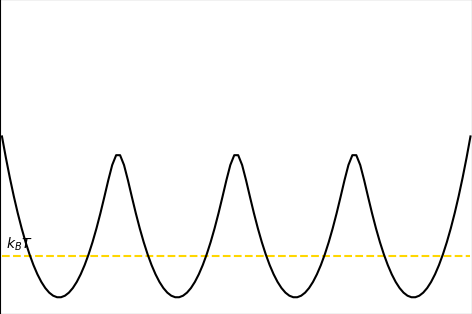

In [110]:

# System parameters
kB    = 0.008314463
T     = 300
mass  = 1
gamma = 1
D     = kB * T / mass / gamma
sigma = np.sqrt(2 * D)
beta  = 1 / kB / T

# Potential energy function
def V(x):
    return 14*(x**3 - 1.5*x)**2 - x**3 + x


def V(x):
    a = 0.06
    #return - 1 / beta * np.log( np.exp( - ( x - 1 ) ** 2 / a ) + np.exp( - ( x + 1 ) ** 2 / a ) )
    return - 1 / beta * np.log( np.exp( - ( x - 0.5 ) ** 2 / a ) + np.exp( - ( x + 0.5 ) ** 2 / a ) +
                                np.exp( - ( x - 1.5 ) ** 2 / a ) + np.exp( - ( x + 1.5 ) ** 2 / a ) )



# Grid
nd     = 1  # Number of dimensions
nedges = 121 # State boundaries
xmin   = -2
xmax   =  2

x      = np.linspace(xmin, xmax, nedges)  # array with x edges
dx     = x[1] - x[0]
x      = x[:-1] + (dx / 2)                # array with x centers
xbins  = nedges - 1
Nbins  = xbins**nd                        # number of bins

fig, (ax1) = plt.subplots(1, 1, figsize=(12*in2cm, 8*in2cm), facecolor='white')
###############################################
ax1.plot(x, kB*T*np.ones(x.shape), '--', color='gold')
ax1.text(-1.95, kB*T+0.5, r'$k_B T$', fontsize = 10)
ax1.plot(x, V(x), 'k', label = 'Potential') 

#ax1.set_title('Potential')
ax1.set_xlabel(r'$x$ / nm')
ax1.set_ylabel(r'$V(x)$ / kJ mol$^{-1}$')
#ax1.legend()
ax1.set_ylim((-1, 18))
ax1.set_xlim((-2, 2))


ax1.set_title('Potential energy function')


plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0.5, hspace=0.8)
#fig.savefig('potential.png', format='png', dpi=900, bbox_inches='tight')

#### Build SqRA 1D

In [111]:
A  = adjancency_matrix_sparse(Nbins, nd, periodic=False)

# Potential energy of states
v = V(x)

# Flux
flux = D / dx**2
Af   = flux * A

# Diagonalization
SQRA = np.sqrt(np.exp(- beta * v))
SQRA = SQRA / sum(SQRA)
Di   = scipy.sparse.spdiags(SQRA, 0, Nbins, Nbins) #.toarray()
D1   = scipy.sparse.spdiags(1/SQRA, 0, Nbins, Nbins)       
Q    = D1 * Af * Di

Q            = Q + scipy.sparse.spdiags(-Q.sum(axis=1).T, 0, Nbins, Nbins)
Qevals, Qevecs = scipy.sparse.linalg.eigs(Q.T, 6, which='LR')
idx    = np.argsort( - np.real(Qevals))
Qevals = Qevals[idx]
Qevecs = Qevecs[:,idx]


Kevals, Kevecs = scipy.sparse.linalg.eigs(Q, 6, which='LR')
idx    = np.argsort( - np.real(Kevals))
Kevals = Kevals[idx]
Kevecs = Kevecs[:,idx]

tau    = np.linspace(0,1,100)

Kevals = np.zeros((6,100))
for i in range(100):
    Kevals[:,i] = np.exp(Qevals * tau[i])

C:\Users\donat\AppData\Local\Temp\ipykernel_12556\3608420724.py:33: ComplexWarning: Casting complex values to real discards the imaginary part
  Kevals[:,i] = np.exp(Qevals * tau[i])


C:\Users\donat\AppData\Local\Temp\ipykernel_12556\2286108464.py:27: RuntimeWarning: invalid value encountered in divide
  ax[2].plot(tau, - tau / np.log(Kevals[1,:]), 'b', label = r'$t_1(\tau)$');
C:\Users\donat\AppData\Local\Temp\ipykernel_12556\2286108464.py:28: RuntimeWarning: invalid value encountered in divide
  ax[2].plot(tau, - tau / np.log(Kevals[2,:]), 'r', label = r'$t_2(\tau)$');
C:\Users\donat\AppData\Local\Temp\ipykernel_12556\2286108464.py:29: RuntimeWarning: invalid value encountered in divide
  ax[2].plot(tau, - tau / np.log(Kevals[3,:]), 'g', label = r'$t_3(\tau)$');
C:\Users\donat\AppData\Local\Temp\ipykernel_12556\2286108464.py:30: RuntimeWarning: invalid value encountered in divide
  ax[2].plot(tau, - tau / np.log(Kevals[4,:]), 'y', label = r'$t_4(\tau)$');
C:\Users\donat\AppData\Local\Temp\ipykernel_12556\2286108464.py:31: RuntimeWarning: invalid value encountered in divide
  ax[2].plot(tau, - tau / np.log(Kevals[5,:]), 'c', label = r'$t_5(\tau)$');


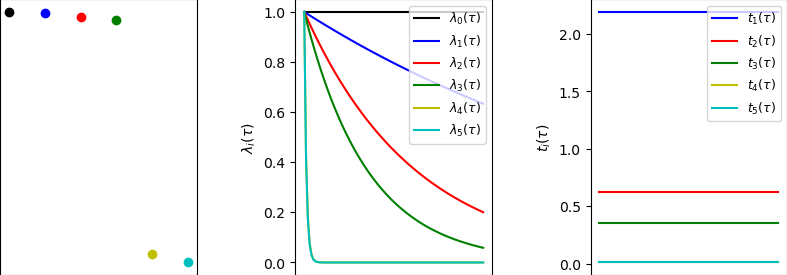

In [112]:
fig, (ax) = plt.subplots(1, 3, figsize=(20*in2cm, 7*in2cm), facecolor='white')


ax[0].plot(0, Qevals[0], 'ko');
ax[0].plot(1, Qevals[1], 'bo');
ax[0].plot(2, Qevals[2], 'ro');
ax[0].plot(3, Qevals[3], 'go');
ax[0].plot(4, Qevals[4], 'yo');
ax[0].plot(5, Qevals[5], 'co');
ax[0].set_xticks([0,1,2,3,4,5])
ax[0].set_xlabel(r'$i$') 
ax[0].set_ylabel(r'$\kappa_i$') 
ax[0].set_title('Eigenvalues $\mathcal{Q}$')

ax[1].plot(tau, Kevals[0,:], 'k', label = r'$\lambda_0(\tau)$');
ax[1].plot(tau, Kevals[1,:], 'b', label = r'$\lambda_1(\tau)$');
ax[1].plot(tau, Kevals[2,:], 'r', label = r'$\lambda_2(\tau)$');
ax[1].plot(tau, Kevals[3,:], 'g', label = r'$\lambda_3(\tau)$');
ax[1].plot(tau, Kevals[4,:], 'y', label = r'$\lambda_4(\tau)$');
ax[1].plot(tau, Kevals[5,:], 'c', label = r'$\lambda_5(\tau)$');
ax[1].set_xlabel(r'$\tau$ / ps') 
ax[1].set_ylabel(r'$\lambda_i(\tau)$') 
ax[1].set_title(r'Eigenvalues $\mathcal{K}_{\tau}$')
ax[1].legend(loc='upper right', fontsize=9)

#ax[2].plot(tau, - tau / np.log(Kevals[0,:]), 'k', label = r'$\lambda_0(\tau)$');
ax[2].plot(tau, - tau / np.log(Kevals[1,:]), 'b', label = r'$t_1(\tau)$');
ax[2].plot(tau, - tau / np.log(Kevals[2,:]), 'r', label = r'$t_2(\tau)$');
ax[2].plot(tau, - tau / np.log(Kevals[3,:]), 'g', label = r'$t_3(\tau)$');
ax[2].plot(tau, - tau / np.log(Kevals[4,:]), 'y', label = r'$t_4(\tau)$');
ax[2].plot(tau, - tau / np.log(Kevals[5,:]), 'c', label = r'$t_5(\tau)$');
ax[2].set_xlabel(r'$\tau$ / ps') 
ax[2].set_ylabel(r'$t_i(\tau)$') 
ax[2].set_title(r'Timescales $t_i(\tau)$')
ax[2].legend(loc='upper right',fontsize=9)


plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0.5, hspace=0.8)
#fig.savefig('evals.png', format='png', dpi=900, bbox_inches='tight')

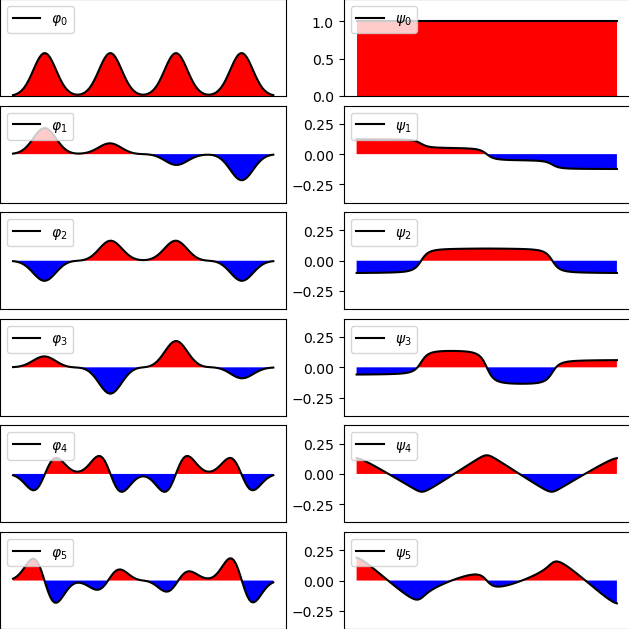

In [113]:
fig, (ax) = plt.subplots(6, 2, figsize=(16*in2cm, 16*in2cm), facecolor='white')


####################################################################################################
y1 = np.zeros(x.shape)
y2 = np.real(Qevecs[:,0])
phi0 = y2 / np.sum( y2*dx)
ax[0,0].plot(x, phi0, 'k-', label= r'$\varphi_0$');
ax[0,0].fill_between(x, y1, phi0, where=phi0 >= y1, facecolor='red', interpolate=True)
ax[0,0].fill_between(x, y1, phi0, where=phi0 < y1, facecolor='blue', interpolate=True)
ax[0,0].set_title('Eigenfunctions $\mathcal{Q}$')
ax[0,0].set_ylim(0,1.3)
ax[0,0].legend(loc='upper left')
ax[0,0].set_xticks([])

y2 = np.real(Kevecs[:,0])
psi0 = y2 / y2
ax[0,1].plot(x, psi0 , 'k-', label= r'$\psi_0$');
ax[0,1].fill_between(x, y1, psi0, where=psi0 >= y1, facecolor='red', interpolate=True)
ax[0,1].fill_between(x, y1, psi0, where=psi0 < y1, facecolor='blue', interpolate=True)
ax[0,1].set_ylim(0,1.3)
ax[0,1].set_title(r'Eigenfunctions $\mathcal{K}_{\tau}$')
ax[0,1].legend(loc='upper left')
ax[0,1].set_xticks([])

####################################################################################################
phi1 = np.real(Qevecs[:,1])
ax[1,0].plot(x, phi1 , 'k-', label= r'$\varphi_1$');
ax[1,0].fill_between(x, y1, phi1, where=phi1 >= y1, facecolor='red', interpolate=True)
ax[1,0].fill_between(x, y1, phi1, where=phi1 < y1, facecolor='blue', interpolate=True)
ax[1,0].legend(loc='upper left')
ax[1,0].set_xticks([])
ax[1,0].set_ylim(-0.4,0.4)

psi1 =  np.real(-Kevecs[:,1])
ax[1,1].plot(x, psi1 , 'k-', label= r'$\psi_1$');
ax[1,1].fill_between(x, y1, psi1, where=psi1 >= y1, facecolor='red', interpolate=True)
ax[1,1].fill_between(x, y1, psi1, where=psi1 < y1, facecolor='blue', interpolate=True)
ax[1,1].legend(loc='upper left')
ax[1,1].set_xticks([])
ax[1,1].set_ylim(-0.4,0.4)

####################################################################################################
phi2 = -np.real(Qevecs[:,2])
ax[2,0].plot(x, phi2 , 'k-', label= r'$\varphi_2$');
ax[2,0].fill_between(x, y1, phi2, where=phi2 >= y1, facecolor='red', interpolate=True)
ax[2,0].fill_between(x, y1, phi2, where=phi2 < y1, facecolor='blue', interpolate=True)
ax[2,0].legend(loc='upper left')
ax[2,0].set_xticks([])
ax[2,0].set_ylim(-0.4,0.4)

psi2 = np.real(Kevecs[:,2])
ax[2,1].plot(x, psi2 , 'k-', label= r'$\psi_2$');
ax[2,1].fill_between(x, y1, psi2, where=psi2 >= y1, facecolor='red', interpolate=True)
ax[2,1].fill_between(x, y1, psi2, where=psi2 < y1, facecolor='blue', interpolate=True)
ax[2,1].legend(loc='upper left')
ax[2,1].set_xticks([])
ax[2,1].set_ylim(-0.4,0.4)

####################################################################################################
phi3 = np.real(Qevecs[:,3])
ax[3,0].plot(x, phi3 , 'k-', label= r'$\varphi_3$');
ax[3,0].fill_between(x, y1, phi3, where=phi3 >= y1, facecolor='red', interpolate=True)
ax[3,0].fill_between(x, y1, phi3, where=phi3 < y1, facecolor='blue', interpolate=True)
ax[3,0].legend(loc='upper left')
ax[3,0].set_xticks([])
ax[3,0].set_ylim(-0.4,0.4)

psi3 = np.real(Kevecs[:,3])
ax[3,1].plot(x, psi3 , 'k-', label= r'$\psi_3$');
ax[3,1].fill_between(x, y1, psi3, where=psi3 >= y1, facecolor='red', interpolate=True)
ax[3,1].fill_between(x, y1, psi3, where=psi3 < y1, facecolor='blue', interpolate=True)
ax[3,1].legend(loc='upper left')
ax[3,1].set_xticks([])
ax[3,1].set_ylim(-0.4,0.4)

####################################################################################################
phi4 = np.real(Qevecs[:,4])
ax[4,0].plot(x, phi4 , 'k-', label= r'$\varphi_4$');
ax[4,0].fill_between(x, y1, phi4, where=phi4 >= y1, facecolor='red', interpolate=True)
ax[4,0].fill_between(x, y1, phi4, where=phi4 < y1, facecolor='blue', interpolate=True)
ax[4,0].legend(loc='upper left')
ax[4,0].set_xticks([])
ax[4,0].set_ylim(-0.4,0.4)

psi4 = - np.real(Kevecs[:,4])
ax[4,1].plot(x, psi4 , 'k-', label= r'$\psi_4$');
ax[4,1].fill_between(x, y1, psi4, where=psi4 >= y1, facecolor='red', interpolate=True)
ax[4,1].fill_between(x, y1, psi4, where=psi4 < y1, facecolor='blue', interpolate=True)
ax[4,1].legend(loc='upper left')
ax[4,1].set_xticks([])
ax[4,1].set_ylim(-0.4,0.4)

####################################################################################################
phi5 = np.real(Qevecs[:,5])
ax[5,0].plot(x, phi5 , 'k-', label= r'$\varphi_5$');
ax[5,0].fill_between(x, y1, phi5, where=phi5 >= y1, facecolor='red', interpolate=True)
ax[5,0].fill_between(x, y1, phi5, where=phi5 < y1, facecolor='blue', interpolate=True)
ax[5,0].legend(loc='upper left')
ax[5,0].set_xticks([])
ax[5,0].set_ylim(-0.4,0.4)
ax[5,0].set_xlabel(r'$x$ / nm')

psi5 = - np.real(Kevecs[:,5])

ax[5,1].plot(x, psi5 , 'k-', label= r'$\psi_5$');
ax[5,1].fill_between(x, y1, psi5, where=psi5 >= y1, facecolor='red', interpolate=True)
ax[5,1].fill_between(x, y1, psi5, where=psi5 < y1, facecolor='blue', interpolate=True)
ax[5,1].legend(loc='upper left')
ax[5,1].set_xticks([])
ax[5,1].set_ylim(-0.4,0.4)
ax[5,1].set_xlabel(r'$x$ / nm')

plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0.2, hspace=0.1)
#fig.savefig('evecs.png', format='png', dpi=900, bbox_inches='tight')

Text(0.5, 0, '$\\psi_1$')

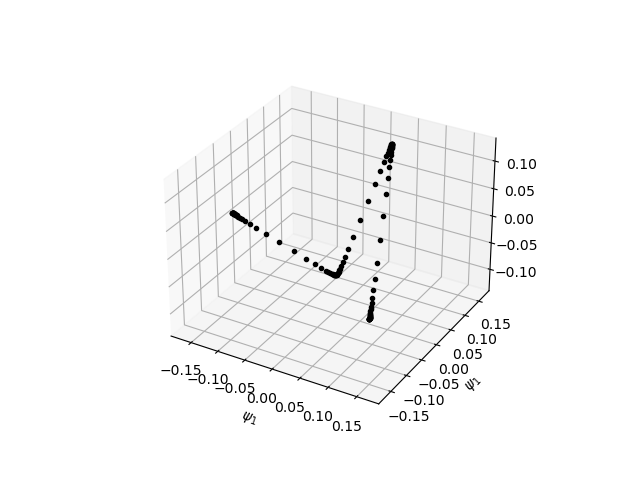

In [120]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.plot(psi1, psi2, psi3, 'k.')
ax.set_aspect('equal')
ax.set_xlabel(r'$\psi_1$')
ax.set_ylabel(r'$\psi_1$')
ax.set_xlabel(r'$\psi_1$')

Optimization terminated successfully.
         Current function value: -296.326949
         Iterations: 358
         Function evaluations: 566


Text(0.5, 0, '$x$')

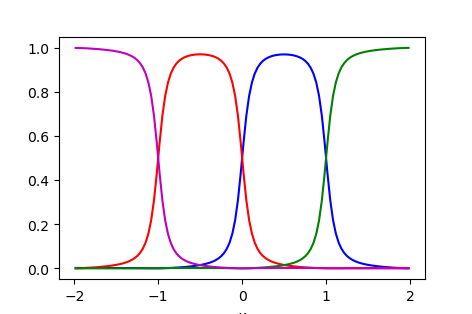

In [121]:
from pcca import pcca

chi = pcca(Q.toarray(), 4)[0]

fig, (ax) = plt.subplots(1, 1, figsize=(12*in2cm, 8*in2cm), facecolor='white')
ax.plot(x, chi[:,0],  'b')
ax.plot(x, chi[:,1],  'r')
ax.plot(x, chi[:,2],  'g')
ax.plot(x, chi[:,3],  'm')
ax.set_xlabel(r'$x$')